# Spin glass optimization


Preamble: Run the cells below to import the necessary Python packages

<!-- *This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.* -->

Open this notebook in Google Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/spin_glass.ipynb)

In [168]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Import plot settings
import requests
code = requests.get("https://raw.githubusercontent.com/williamgilpin/cphy/main/cphy/template.py", timeout=10).text
exec(code, globals(), globals())

# Spin glasses and the Sherrington-Kirkpatrick model

The Sherrington-Kirkpatrick (SK) model is a model of a spin glass, a system of spins that are coupled to each other. The spins are Ising spins, which can be either up or down, and the coupling between spins is given by a matrix $J_{ij}$. The Hamiltonian of the system is given by:

$$
H = - \sum_{i<j} J_{ij} s_i s_j - \sum_i h_i s_i
$$

where $s_i$ is the spin of the $i$-th spin, $J_{ij}$ is the symmetric coupling between the $i$-th and $j$-th spins, and $h_i$ is the external field on the $i$-th spin. While the spins are discrete, the elements of $J_{ij}$ are continuous. In typical settings, the couplings are drawn from a Gaussian distribution with mean 0 and standard deviation $\sigma$.

### Implementing the SK model

We implement the SK model in Python. Our class `SherringtonKirkpatrickSpinGlass` will take, at initialization, the number of spins $N$, and the external fields $h_i$, the standard deviation of the Gaussian couplings $J_{ij}$, and the random number generator.

In [144]:
import numpy as np

class SherringtonKirkpatrickSpinGlass:
    """
    Sherrington-Kirkpatrick (SK) spin glass with Ising spins (-1 or +1).

    Parameters:
        n (int): Number of spins.
        h (float or ndarray): External field; defaults to zero.
        J (ndarray or None): Coupling matrix; defaults to i.i.d. Gaussian.
        random_state (int): Random number generator seed.
    """
    def __init__(self, n, h = 0, J = None, random_state = None):
        self.n = n
        self.random_state = random_state
        self.h = h * np.ones(self.n) 
        self.sigma = 1.0 / np.sqrt(self.n)

        if J is None:
            ## i.i.d. Gaussian, then symmetrize and zero diagonal
            np.random.seed(self.random_state)
            self.J = np.random.normal(loc=0.0, scale=self.sigma, size=(self.n, self.n))
            self.J = (self.J + self.J.T).astype(float)  # symmetric
            np.fill_diagonal(self.J, 0.0) # Set diagonal to zero

        else:
            self.J = J

    def energy(self, s) -> float:
        f"""Return H(s) for a spin configuration s."""
        return float(-0.5 * s @ (self.J @ s) - self.h @ s)

    def random_spins(self):
        """Sample a random spin configuration"""
        return np.random.choice(np.array([-1, 1], dtype=int), size=self.n)

    def energy_delta(self, s, i):
        """
        Energy change ΔH from flipping spin i. Faster than calling the `energy` method 
            twice.
        """
        return float(2.0 * s[i] * (self.h[i] + self.J[i] @ s))


Energy: 7.470277805459646


Text(0.5, 1.0, 'Coupling Matrix')

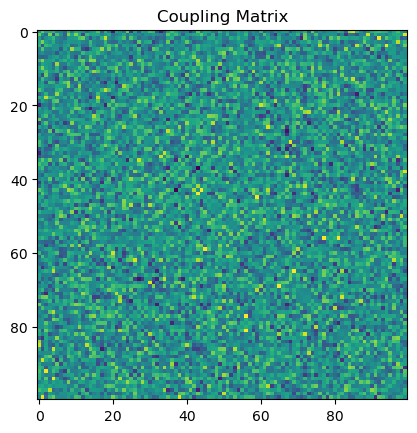

In [145]:
sk = SherringtonKirkpatrickSpinGlass(n=100, random_state=0)
s = sk.random_spins()
print("Energy:", sk.energy(s))

plt.figure()
plt.imshow(sk.J)
plt.title("Coupling Matrix")

# Simulated annealing

**Simulated annealing (SA)** is a stochastic optimization method inspired by the process of slowly cooling a physical system into its ground state. The algorithm steps resemble Monte Carlo sampling, but with a temperature parameter $T$ that is gradually decreased.

1. Start with a random configuration of the system. For the SK model, this is given by an initial spin configuration $\mathbf{s} \in \{-1,+1\}^N$.  

2. At each step, propose a small change. For the SK model, this is given by flipping a single spin, $s_i \to -s_i$ for some $i \in \{1, \ldots, N\}$.

3. If the change **lowers the energy**, accept it.  
4. If the change **raises the energy** by $\Delta E$, accept it with probability $p = e^{-\beta \Delta E}$, just as in Metropolis sampling. As with the Metropolis algorithm, $\beta = 1/k_B T$ sets an inverse energy scale for the system.

5. Gradually reduce the temperature $T$ from a high initial value $T_0$ to a low final value $T_f$. This is the critical difference between SA and the Metropolis algorithm.

The idea behind simulated annealing is to balance **exploration** (avoiding poor local minima and exploring the large set of possible spin configurations) and **exploitation** (refining a candidate solution). The system favors exploration (high temperature) at the beginning of the optimization, and exploitation (low temperature) as it approaches the ground state.


## Implementing simulated annealing

We will implement a `SimulatedAnnealingOptimizer` class that wraps this algorithm. The constructor takes a landscape object with an `energy` method and a `flip_energy_delta` method, which we will use to compute the energy and energy change for a given spin configuration. The optimizer returns the best spin configuration found and the corresponding minimum energy, as well as a dictionary of information about the optimization trajectory.

This algorithm mirrors the physics of annealing: at high temperature spins fluctuate freely, while gradual cooling encourages the system to settle into an approximate ground state.


-96.0135101475796


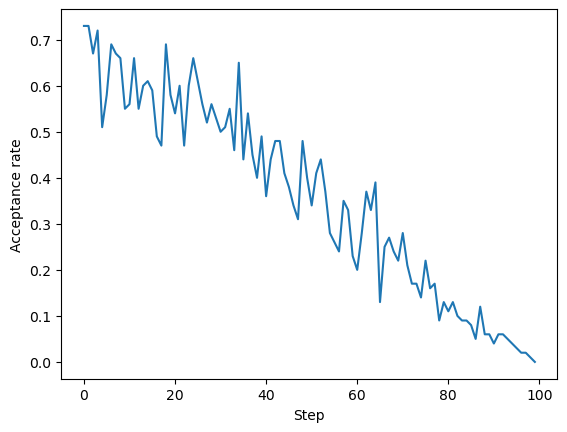

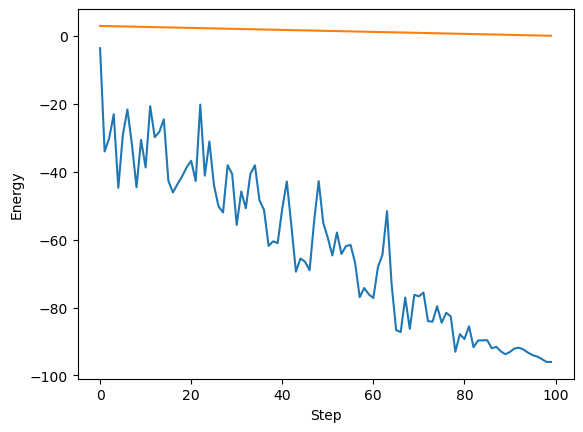

In [146]:
class SimulatedAnnealing:
    """
    Minimal simulated annealing for an Ising-like system.
    """
    def __init__(self, random_state = None, store_history = True):
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.store_history = store_history
        if self.store_history:
            self.spins_history = []
            self.energies_history = []
            self.acceptance_history = []

    def fit(self, system, temperatures):

        self.spins = system.random_spins()
    
        N = self.spins.size
        for T in np.asarray(temperatures, dtype=float):

            # One sweep per temperature: N random single-spin proposals
            accept_count = 0
            for _ in range(N):
                
                ## Sample a random lattice site with replacement
                i = np.random.randint(0, N)
                dE = system.energy_delta(self.spins, i)

                # Metropolis acceptance
                if dE <= 0.0:
                    accept = True
                else:
                    accept = np.random.random() < np.exp(-dE / T)

                if accept:
                    # Flip in-place; system is expected to be mutable
                    accept_count += 1
                    self.spins[i] = -self.spins[i]
            
            if self.store_history:
                self.spins_history.append(self.spins.copy())
                self.energies_history.append(system.energy(self.spins))
                self.acceptance_history.append(accept_count / N)
        return system.energy(self.spins), self.spins

temperatures = np.linspace(3.0, 0.1, 100)
sa = SimulatedAnnealing()
final_E, final_spins = sa.fit(sk, temperatures)
print(final_E)


plt.figure()
plt.plot(sa.acceptance_history)
plt.xlabel("Step")
plt.ylabel("Acceptance rate")
plt.show()

plt.figure()
plt.plot(sa.energies_history)
plt.plot(temperatures)
plt.xlabel("Step")
plt.ylabel("Energy")
plt.show()


## Annealing schedules and learning rate schedules

Above, we lower the temperature $T$ linearly. This is a common choice, but not the only one. We can also use a **geometric** schedule, where $T$ is multiplied by a factor $r$ at each step:

$$
T_{i+1} = r T_i
$$

We can also use a **logarithmic** schedule, where $T$ is divided by a factor $c$ at each step:

$$
T_{i+1} = T_i / (1 + c \log(i))
$$

We will try implementing these alternate schedules, to see how they perform.


In [147]:
def geometric_schedule(T0, Tf, n_steps):
    if n_steps < 2:
        return np.array([Tf], dtype=float)
    r = (Tf / T0) ** (1.0 / (n_steps - 1))
    return T0 * (r ** np.arange(n_steps))

def linear_schedule(T0, Tf, n_steps):
    return np.linspace(T0, Tf, n_steps, dtype=float)

def log_schedule(T0, c, n_steps):
    ks = np.arange(n_steps)
    return T0 / (1.0 + c * np.log1p(ks))


temperatures = linear_schedule(3.0, 0.01, 100)
# temperatures = log_schedule(3.0, 0.01, 100)
# temperatures = geometric_schedule(3.0, 0.01, 100)
sa = SimulatedAnnealing()
final_E, final_spins = sa.fit(sk, temperatures)
print(final_E)


-92.14484392099364


In modern large language models, the temperature schedule is typically a **cosine** schedule, corresponding to repeatedly raising and lowering the temperature. This can help prevent the model from getting stuck in deep local minima.

In [158]:
def cosine_schedule(T0, Tf, n_steps, periods=2):
    """
    Cosine schedule that starts at T0 at the peak of a cosine wave, and ends at Tf at the trough.
    It performs periods total cycles across n_steps steps.
    """
    # Choose the smallest half-integer number of cycles >= periods
    m = max(0, np.ceil(periods - 0.5))     # integer
    cycles = m + 0.5                    # half-integer to end at a trough
    dphi = 2 * np.pi * cycles              # total phase across the schedule

    # Build schedule using a 0..1 normalized parameter so endpoints land at 0 and 1 exactly
    denom = n_steps - 1
    sched = [
        Tf + (T0 - Tf) * (1 + np.cos((i / denom) * dphi)) / 2
        for i in range(n_steps)
    ]

    # Ensure exact endpoints (numerical safety)
    sched[0] = T0
    sched[-1] = Tf
    return sched

temperatures = cosine_schedule(3.0, 0.01, 100, periods=3)
sa = SimulatedAnnealing()
final_E, final_spins = sa.fit(sk, temperatures)
print(final_E)

-91.4524947016983


We can get a better sense of the performance of these different schedules by running the optimization many times and plotting the distribution of the final energies for each scheduling method.

Trial 0
Trial 10
Trial 20
Trial 30
Trial 40
Trial 50
Trial 60
Trial 70
Trial 80
Trial 90


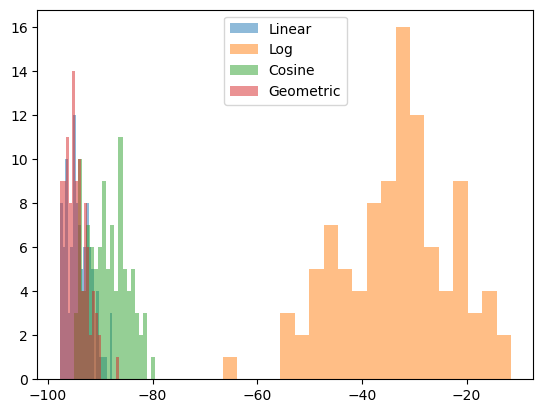

In [159]:

all_linear, all_log, all_cosine, all_geometric = [], [], [], []
for i in range(100):
    if i % 10 == 0:
        print(f"Trial {i}")
    temperatures = linear_schedule(3.0, 0.01, 100)
    sa = SimulatedAnnealing()
    all_linear.append(sa.fit(sk, temperatures)[0])

    temperatures = log_schedule(3.0, 0.01, 100)
    sa = SimulatedAnnealing()
    all_log.append(sa.fit(sk, temperatures)[0])

    temperatures = cosine_schedule(3.0, 0.01, 100, periods=3)
    sa = SimulatedAnnealing()
    all_cosine.append(sa.fit(sk, temperatures)[0])

    temperatures = geometric_schedule(3.0, 0.01, 100)
    sa = SimulatedAnnealing()
    all_geometric.append(sa.fit(sk, temperatures)[0])


plt.figure()
plt.hist(all_linear, bins=20, alpha=0.5, label="Linear")
plt.hist(all_log, bins=20, alpha=0.5, label="Log")
plt.hist(all_cosine, bins=20, alpha=0.5, label="Cosine")
plt.hist(all_geometric, bins=20, alpha=0.5, label="Geometric")
plt.legend()
plt.show()


# How well did we do? The analytic prediction in the many spin case

We can compare the results of our simulated annealing algorithm to the analytic prediction for the ground state energy of the Sherrington-Kirkpatrick model. In the $N\to\infty$ limit, [various]((https://www.google.com/books/edition/_/DwY8DQAAQBAJ)) analytic [techniques](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.65.046137) based on the replica method estimate a constant energy density of approximately $-0.76321 \sqrt{2}$.

$$
    \mathbb{E}[E_0] = -0.76321 \sqrt{2} \,N
$$

where $N$ is the number of spins. Note that this value is independent of $J$ because we took the $N\to\infty$ limit. We can compare the results of our simulated annealing algorithm to the analytic prediction.
<!-- https://intlpress.com/site/pub/files/_fulltext/journals/cdm/2014/2014/0001/CDM-2014-2014-0001-a004.pdf -->



In [174]:
def analytic_ground_state_energy(n: int) -> float:
    """Returns the approximate ground state energy in the many spin limit"""
    return float(-n * 0.76321 * np.sqrt(2))

analytic_ground_state_energy(sk.n)


-97.1407739644893

We expect that the gap between the predicted and actual ground state arises due to three effects:

1. The finite size of the system.
2. The finite temperature of the system.
3. Randomness in the couplings.
4. Insufficient optimization.

We can try improving our optimizer, to see if a better optimizer can close the gap.

<br><br><br><br><br><br>









## Replica exchange Monte Carlo

We can improve the performance of our optimizer by running multiple replicas at different temperatures. This is the idea behind replica exchange Monte Carlo (REMC). We will implement a simple version of this algorithm, which is known as **parallel tempering**. We will run $R$ replicas at different temperatures, and periodically attempt swaps between neighboring replicas based on the Boltzmann distribution.

In replica exchange, we initialize $R$ replicas at different temperatures. We have two loops: and outer loop that sweeps through replica pairs, and an inner loop that runs simulated annealing on each replica.

After a round of simulated annealing sweeps, we attempt to swap each replica. Suppose that one replica is at temperature $T_1$ and has energy $E_1$, and another replica is at temperature $T_2$ and has energy $E_2$. The probability of accepting a swap is

$$
    p_{\text{swap}} = \min\left(1, \frac{T_2}{T_1} \exp\left(\frac{E_1 - E_2}{T_1}\right)\right)
$$

Essentially, we are proposing a swap that we always accept if the energy of the replica at the higher temperature is lower, and otherwise accept it with probability $T_2/T_1$ if the energy of the replica at the lower temperature is lower. We are thus performing a Metropolis step that minimizes the energy of the lower temperature replica.




In [207]:
class SimulatedAnnealingReplicaExchange:
    """
    Minimal simulated annealing for an Ising-like system.
    """
    def __init__(self, random_state=None, store_history=True):
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.store_history = store_history
        if self.store_history:
            self.spins_history = []
            self.energies_history = []
            self.acceptance_history = []

    # --- Minimal Replica Exchange (Parallel Tempering) ---
    def fit(self, system, temperatures, n_cycles=100):
        """
        Minimal replica exchange. Run R replicas at fixed temperatures and periodically
        attempt swaps between neighboring temperatures.

        Args:
            system: object with random_spins(), energy(spins), energy_delta(spins, i)
            temperatures: array-like of R fixed temperatures (high -> low recommended)
            n_cycles: number of [local sweeps + swap attempts] cycles

        Returns:
            (best_energy, best_spins)
        """
        R = len(temperatures)

        # Initialize replicas independently
        spins_list = [system.random_spins() for _ in range(R)]
        energies = np.array([system.energy(s) for s in spins_list], dtype=float)
        N = spins_list[0].size

        # (Very) light tracking
        flip_acc_counts = np.zeros(R, dtype=int)
        flip_tot_counts = np.zeros(R, dtype=int)
        swap_accepts = 0
        swap_total = 0

        for k in range(n_cycles):
            
            # Simulated annealing sweeps (one sweep per replica)
            for r, T in enumerate(temperatures):
                s = spins_list[r]
                for _ in range(N):
                    i = np.random.randint(0, N)
                    dE = system.energy_delta(s, i)
                    if dE <= 0.0 or (T > 0.0 and np.random.random() < np.exp(-dE / T)):
                        s[i] = -s[i]
                        energies[r] += dE
                        flip_acc_counts[r] += 1
                    flip_tot_counts[r] += 1

            # Neighbor swaps: even-odd scheme to touch all pairs
            # for r in range(k % 2, R - 1, 2):
            
            pairs = list(range(R - 1))
            np.random.shuffle(pairs)
            for r in pairs:
                # Get temperatures and energies of two replicas
                Ti, Tj = temperatures[r], temperatures[r + 1]
                Ei, Ej = energies[r], energies[r + 1]
                
                # Swap acceptance: exp[(1/Ti - 1/Tj)*(Ej - Ei)]
                d = (1.0 / Ti - 1.0 / Tj) * (Ej - Ei)
                if d > 0.0:
                    accept = (np.random.random() < np.exp(-d))
                else:
                    accept = True

                if accept:
                    spins_list[r], spins_list[r + 1] = spins_list[r + 1], spins_list[r]
                    energies[r], energies[r + 1] = energies[r + 1], energies[r]
                    swap_accepts += 1

                swap_total += 1

            if self.store_history:
                # Store best replica snapshot of this cycle
                best_idx = int(np.argmin(energies))
                self.spins_history.append(spins_list[best_idx].copy())
                self.energies_history.append(float(energies[best_idx]))
                mean_flip_acc = float(
                    np.mean(flip_acc_counts / np.maximum(1, flip_tot_counts))
                )
                # acceptance_history holds (mean_local_flip_acceptance, cumulative_swap_acceptance)
                self.acceptance_history.append(
                    (mean_flip_acc, swap_accepts / max(1, swap_total))
                )

        best_idx = int(np.argmin(energies))
        return float(energies[best_idx]), spins_list[best_idx]


sa_replica_exchange = SimulatedAnnealingReplicaExchange(random_state=0)
# temperatures1 = geometric_schedule(3.0, 0.01, 100)
temperatures = geometric_schedule(5.0, 0.1, 10)
# temperatures3 = cosine_schedule(3.0, 0.01, 100, periods=3)
# all_temperatures = np.array([temperatures1, temperatures2, temperatures3])
final_E, final_spins = sa_replica_exchange.fit(sk, temperatures, n_cycles=100)
print(final_E)


-93.01554633299165


It looks better, but we used a lot more compute to do this. Let's compare this solution with the case where we don't do replica exchange and just run simulated annealing multiple times.

In [208]:
all_sa_min = []
for i in range(100):
    sa = SimulatedAnnealing(random_state=i)
    final_E, final_spins = sa.fit(sk, temperatures)
    all_sa_min.append(final_E)
print(np.min(all_sa_min))

-92.68779296422763


A key advantage of replica exchange is that it allows us to use parallel computing. Each annealing sweep is independent of the others, and so we can assign each replica to its own core on a multi-core machine. The exchange step allows information found by the different replicas to be shared, thus selectively coupling the dynamics across cores and allowing slightly better results than if we just ran simulated annealing alone in parallel.

When optimizing for a multi-core machine, we can select pairs of replicas using a more sophisticated method than random selection. For example, we can select pairs of replicas that are close in temperature, or in energy, or even based on physical proximity on our hardware.

<br><br><br><br>

## Approaching the replica limit

We can try varying $N$ and see how the gap changes, in order to understand finite size effects. [Prior](https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10005) [numerical](https://link.springer.com/article/10.1140/epjb/e2005-00280-6) [studies](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.76.184412) estimate the the gap between the finite and infinite size ground states decreases as $\sim N^{-0.67}$.

In [217]:
nvals = np.arange(10, 200, 10)

all_sa_min, all_sare_min, all_gs_inf = [], [], []
for nval in nvals:
    print(f"n={nval}")
    sk = SherringtonKirkpatrickSpinGlass(n=nval, random_state=0)

    sa = SimulatedAnnealing()
    final_E, final_spins = sa.fit(sk, temperatures)
    all_sa_min.append(final_E)

    sare = SimulatedAnnealingReplicaExchange()
    final_E, final_spins = sare.fit(sk, temperatures)
    all_sare_min.append(final_E)

    gs_inf = analytic_ground_state_energy(sk.n)
    all_gs_inf.append(gs_inf)

all_sare_min = np.array(all_sare_min)
all_sa_min = np.array(all_sa_min)
all_gs_inf = np.array(all_gs_inf)


n=10
n=20
n=30
n=40
n=50
n=60
n=70
n=80
n=90
n=100
n=110
n=120
n=130
n=140
n=150
n=160
n=170
n=180
n=190


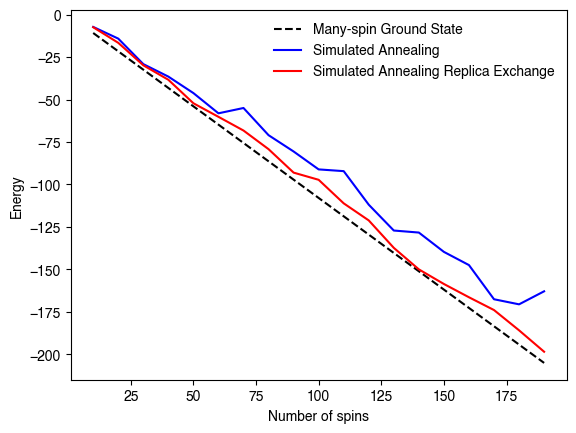

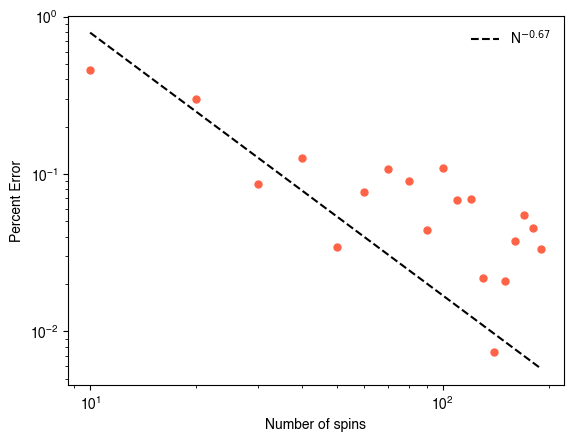

In [237]:
plt.figure()
plt.plot(nvals, all_gs_inf, "--k",label="Many-spin Ground State")
plt.plot(nvals, all_sa_min, color="blue",label="Simulated Annealing")
plt.plot(nvals, all_sare_min, color="red",label="Simulated Annealing Replica Exchange")
plt.xlabel("Number of spins")
plt.ylabel("Energy")
plt.legend(frameon=False)
plt.show()

shift_factor = 40 # We use this to align the dashed scaling line with the data
plt.figure()
plt.loglog(nvals, (all_sare_min - all_gs_inf) / np.abs(all_sare_min), ".")
plt.loglog(nvals, -(nvals**-0.67) / all_gs_inf * shift_factor, "--k",label="N$^{-0.67}$")
plt.xlabel("Number of spins")
plt.ylabel("Percent Error")
plt.legend(frameon=False)
plt.show()



## NP-hard problems

What if we wanted to find the global ground state of a spin glass? For a spin glass with $N$ spins, we need to search over $2^N$ possible states. This is known as combinatorial optimization. It is a worst-case scenario for optimization over discrete variables. Spin glass minimization is an example of an NP-hard problem. Other problems in this class include the traveling salesman problem, the graph coloring problem, the integer linear programming problem, as well as many problems in biology and chemistry.

In computer science, we say that a problem is NP-hard if the best known algorithm for the problem has a runtime that grows faster than any polynomial in the size of the problem. For example, the best known algorithm for the traveling salesman problem has a runtime that grows as $O(N^2 2^N)$, where $N$ is the number of cities visited.

We can still make progress for NP-hard problems by using heuristics. Simulated annealing found a low energy state of our spin glass in finite time. However, there are not guarantees regarding the distance between this solution and the global ground state over all possible spin glass instances.

NP-hard problems can be transformed onto one another, a process known as reduction. If we can reduce a problem $A$ to a problem $B$, and we know how to solve problem $B$ efficiently, then we can solve problem $A$ efficiently.

Here, we consider the case of solving a Sudoku puzzle, which is a classic example of a combinatorial optimization problem. We will define a $3 x 3$ Sudoku puzzle, and then transform it into a spin glass. We will then use simulated annealing to find a solution to the Sudoku puzzle.



In [323]:
# A 3×3 Latin-square puzzle (np.nan = unknown)
puz = np.array([
    [1,   np.nan, np.nan],
    [np.nan, 3,   np.nan],
    [np.nan, np.nan, 2]
], dtype=float)
print(puz)

[[ 1. nan nan]
 [nan  3. nan]
 [nan nan  2.]]


To convert this into a spin glass, we will use a high level heuristic: Imagine that we define 3 spins for each cell in the Sudoku puzzle, one for each possible digit. As a result, we have a total of $3 \times 9 = 27$ spins.

For each set of 3 spins associated with a cell, we assign elements to the $27 x 27$ constraint matrix such that it is energetically unfavorable to have more than one spin up in the row. Whichever spin is up will correspond to the digit that is present in the cell.

To enforce the constraint that we can only have one of each digit in each row or column, we can use a similar strategy.

Lastly, a Sudoku puzzle is constrained in part by the specified starting digits. We will enforce that these stay constant by inserting a strong local field $h_i$ that fixes the value of the spin to the digit that is present in those cells. We will leave the local field equal to zero for the spins associated with unknown cells.

### The code cell below was generated with assistance from Claude Code.

In [ ]:
import numpy as np
from itertools import combinations
from math import isclose, sqrt

def puzzle_to_ising(
    puzzle: np.ndarray,
    *,
    include_subgrid: str | bool = "auto",  # "auto" -> add subgrid constraints if n is a perfect square
    w_cell: float = 1.0,                   # cell one-hot weight
    w_row: float  = 1.0,                   # row uniqueness weight
    w_col: float  = 1.0,                   # column uniqueness weight
    w_block: float = 1.0,                  # subgrid uniqueness weight (if enabled)
    w_clue: float = 3.0,                   # clue weight
    return_mapping: bool = False           # also return index↔(r,c,v) mapping if True
):
    """
    Build an Ising spin-glass encoding for a Latin-square / Sudoku puzzle.

    Inputs
    ------
    puzzle : np.ndarray (n x n), dtype float or int
        Known digits in 1..n, unknowns as np.nan.

    include_subgrid : "auto" | bool
        If True, include sqrt(n) x sqrt(n) block constraints (i.e., classic Sudoku).
        If "auto", include blocks only when sqrt(n) is an integer (>1).

    Weights w_* : float
        Penalty weights for each family of constraints.

    Returns
    -------
    J : np.ndarray (N x N)
        Symmetric coupling matrix with zeros on the diagonal, where N = n^3.

    h : np.ndarray (N,)
        Local fields.

    (Optional) idx_map, rev_map, const
        If return_mapping=True, also returns:
          - idx_map: dict[(r,c,v)] -> i  (0-based indices; digits v in 1..n)
          - rev_map: dict[i] -> (r,c,v)
          - const  : constant energy offset for the Ising Hamiltonian

    Notes
    -----
    Variables:
        For each cell (r,c) and digit v ∈ {1..n}, define binary x_{r,c,v} ∈ {0,1}.
        Spins: s_i ∈ {-1,+1}, with x_i = (1 + s_i)/2.

    Constraints encoded (as QUBO sums of squares):
      1) Cell one-hot:      (sum_v x_{r,c,v} - 1)^2
      2) Row uniqueness:    (sum_c x_{r,c,v} - 1)^2   for each row r, digit v
      3) Column uniqueness: (sum_r x_{r,c,v} - 1)^2   for each column c, digit v
      4) Subgrid uniqueness (optional): for each block B and digit v,
                                     (sum_{(r,c)∈B} x_{r,c,v} - 1)^2
      5) Clues: for each given (r,c)=v*, (x_{r,c,v*} - 1)^2

    Conversion:
        From QUBO E(x)=x^T Q x + const to Ising
        E(s) = sum_{i<j} J_ij s_i s_j + sum_i h_i s_i + const',
        with J = Q/4 (diag set to 0), h = (Q 1)/2, const' = const + (1^T Q 1)/4.
    """
    # --- validate puzzle ---
    puzzle = np.asarray(puzzle)
    if puzzle.ndim != 2 or puzzle.shape[0] != puzzle.shape[1]:
        raise ValueError("puzzle must be a square 2D array")
    n = puzzle.shape[0]
    if n < 2:
        raise ValueError("n must be at least 2")

    # Check digits: allow np.nan for blanks; non-NaN must be integers in 1..n
    flat = puzzle[~np.isnan(puzzle)]
    if flat.size:
        if not np.all(np.equal(np.floor(flat), flat)):
            raise ValueError("Known cells must be integers.")
        if not np.all((flat >= 1) & (flat <= n)):
            raise ValueError(f"Known digits must be in 1..{n}")

    # Determine whether to add subgrid constraints
    if include_subgrid == "auto":
        rt = sqrt(n)
        use_blocks = isclose(rt, int(rt)) and int(rt) > 1
    else:
        use_blocks = bool(include_subgrid)

    block = int(round(sqrt(n))) if use_blocks else 1  # block size if enabled

    # --- variable indexing: i ↔ (r,c,v) ---
    idx_map = {}
    rev_map = {}
    k = 0
    for r in range(n):
        for c in range(n):
            for v in range(1, n + 1):
                idx_map[(r, c, v)] = k
                rev_map[k] = (r, c, v)
                k += 1
    N = k

    # We'll accumulate an upper-triangular QUBO (i<=j), then symmetrize.
    Q_ut = np.zeros((N, N), dtype=float)
    const_qubo = 0.0

    def add_sum_equals_one(vars_idx, weight):
        """
        Add (sum x - 1)^2 with given weight.
        Expands to: -weight*sum_i x_i + 2*weight*sum_{i<j} x_i x_j + weight
        """
        nonlocal const_qubo
        if weight == 0 or not vars_idx:
            return
        # linear
        for i in vars_idx:
            Q_ut[i, i] += -weight
        # pairwise
        for a, b in combinations(vars_idx, 2):
            i, j = (a, b) if a < b else (b, a)
            Q_ut[i, j] += 2.0 * weight
        const_qubo += weight

    # 1) Cell one-hot per (r,c)
    for r in range(n):
        for c in range(n):
            vars_rc = [idx_map[(r, c, v)] for v in range(1, n + 1)]
            add_sum_equals_one(vars_rc, w_cell)

    # 2) Row uniqueness for each (r, v)
    for r in range(n):
        for v in range(1, n + 1):
            vars_rv = [idx_map[(r, c, v)] for c in range(n)]
            add_sum_equals_one(vars_rv, w_row)

    # 3) Column uniqueness for each (c, v)
    for c in range(n):
        for v in range(1, n + 1):
            vars_cv = [idx_map[(r, c, v)] for r in range(n)]
            add_sum_equals_one(vars_cv, w_col)

    # 4) Subgrid uniqueness for each block B and digit v (if enabled)
    if use_blocks:
        b = block  # block size (sqrt(n))
        for br in range(0, n, b):
            for bc in range(0, n, b):
                cells = [(r, c) for r in range(br, br + b) for c in range(bc, bc + b)]
                for v in range(1, n + 1):
                    vars_Bv = [idx_map[(r, c, v)] for (r, c) in cells]
                    add_sum_equals_one(vars_Bv, w_block)

    # 5) Clues: (x - 1)^2 = -x + 1 (weighted)
    for r in range(n):
        for c in range(n):
            if not np.isnan(puzzle[r, c]):
                v_star = int(puzzle[r, c])
                i = idx_map[(r, c, v_star)]
                Q_ut[i, i] += -w_clue
                const_qubo += w_clue

    # --- symmetrize Q so that E(x) = x^T Q x + const ---
    Q = Q_ut.copy()
    for i in range(N):
        for j in range(i + 1, N):
            # In x^T Q x, the cross term coefficient is 2*Q_ij.
            # We stored the full cross coefficient in upper triangle; halve when symmetrizing.
            val = Q_ut[i, j] * 0.5
            Q[i, j] = val
            Q[j, i] = val

    # --- convert QUBO → Ising ---
    ones = np.ones(N)
    J = Q / 2.0           # ← was Q/4.0; with symmetric Q the correct factor is 1/2
    np.fill_diagonal(J, 0.0)
    h = (Q @ ones) / 2.0
    const_ising = (ones @ Q @ ones) / 4.0
    const_total = const_qubo + const_ising

    if return_mapping:
        return J, h, idx_map, rev_map, const_total
    return J, h

def spins_to_grid_energy(spins, J, h, idx_map):
    """
    Project a spin solution s ∈ {-1,+1}^N to a valid n×n grid by choosing,
    in each cell, the digit with the most negative effective field
        f_i = h_i + sum_j J_ij s_j
    which is the digit whose flip to +1 yields the largest energy decrease.

    Parameters
    ----------
    spins : (N,) array_like of {-1,+1}
    J     : (N,N) ndarray, couplings (zero diagonal)
    h     : (N,)   ndarray, local fields
    idx_map : dict[(r,c,v)] -> i  with v in 1..n

    Returns
    -------
    grid : (n,n) ndarray of int in 1..n
    """
    s = np.asarray(spins, dtype=float).ravel()
    f = h + J @ s  # effective field on each spin

    # infer n
    keys = np.array(list(idx_map.keys()))
    n = int(max(keys[:,0].max(), keys[:,1].max())) + 1

    grid = np.zeros((n, n), dtype=int)
    for r in range(n):
        for c in range(n):
            idxs = [idx_map[(r, c, v)] for v in range(1, n+1)]
            # pick digit with smallest f_i (strongest incentive to be +1)
            v_hat = 1 + int(np.argmin(f[idxs]))
            grid[r, c] = v_hat
    return grid

Text(0.5, 1.0, '3x3 Sudoku encoded as a 27x27 coupling matrix')

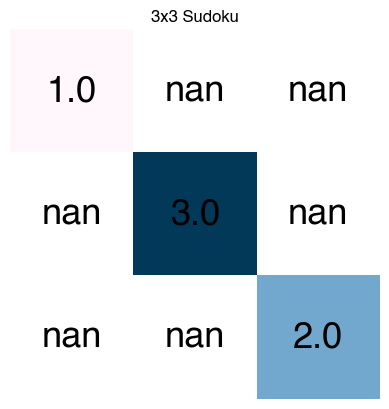

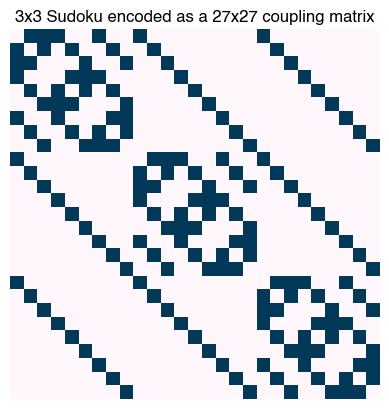

In [325]:
# Example: 3×3 Latin-square puzzle (np.nan = unknown)
puz = np.array([
    [1,   np.nan, np.nan],
    [np.nan, 3,   np.nan],
    [np.nan, np.nan, 2]
], dtype=float)

J, h = puzzle_to_ising(puz)

plt.figure()
plt.imshow(puz)
plt.gca().set_axis_off()
for i in range(3):
    for j in range(3):
        plt.text(j, i, str(puz[i,j]), ha="center", va="center", fontsize=26)
plt.title("3x3 Sudoku")

plt.figure()
plt.imshow(J)
plt.gca().set_axis_off()
plt.title("3x3 Sudoku encoded as a 27x27 coupling matrix")



We can now use our spin glass solver to minimize the energy of this system.

-348.75


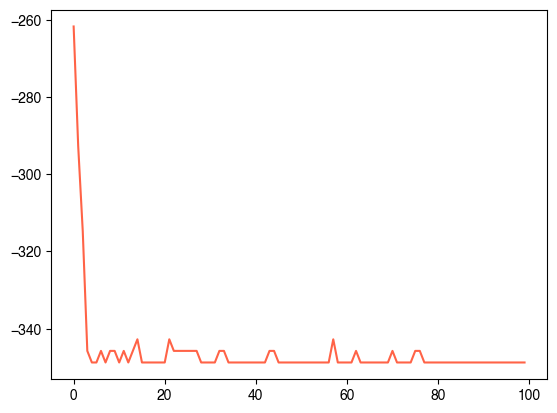

In [327]:
sk = SherringtonKirkpatrickSpinGlass(J.shape[0], J=-J, h=10*h, random_state=0)

temperatures = linear_schedule(3.0, 0.01, 100)
sa = SimulatedAnnealing()
final_E, final_spins = sa.fit(sk, temperatures)
print(final_E)

plt.figure()
plt.plot(sa.energies_history)

Text(0.5, 1.0, '3x3 Sudoku')

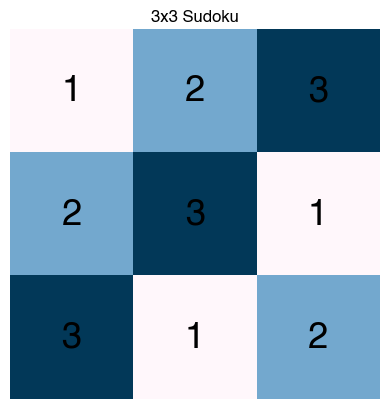

In [329]:
puz_sol = spins_to_grid(final_spins, sk.J, sk.h)

plt.figure()
plt.imshow(puz_sol)
plt.gca().set_axis_off()
for i in range(3):
    for j in range(3):
        plt.text(j, i, str(puz_sol[i, j]), ha="center", va="center", fontsize=26)
plt.title("3x3 Sudoku")

In [ ]:
frames = [spins_to_grid(item, sk.J, sk.h) for item in sa.spins_history]

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
# im = ax.imshow(frames[0], vmin=0, vmax=3)
# # plot digits on top of the image
# for i in range(3):
#     for j in range(3):
#         ax.text(j, i, str(frames[0][i,j]), ha="center", va="center", fontsize=26)
im = ax.imshow(frames[0], vmin=0, vmax=3, animated=True)
# create and keep handles to the text artists (no new texts per frame)
H, W = frames[0].shape
text_objs = [[ax.text(j, i, str(frames[0][i, j]),
                      ha="center", va="center", fontsize=26)
              for j in range(W)] for i in range(H)]
ax.set_axis_off()

def update_frame(frame_idx):
    im.set_data(frames[frame_idx])
    for i in range(H):
        for j in range(W):
            text_objs[i][j].set_text(str(frames[frame_idx][i, j]))
    # return all animated artists for blitting
    return [im] + [t for row in text_objs for t in row]
    # return im

anim = FuncAnimation(fig, update_frame, frames=len(frames[:50]), interval=200, blit=False)

html = HTML(anim.to_jshtml(default_mode="loop"))


plt.rcParams["animation.html"] = "jshtml"  # use JS-based display (no ffmpeg needed)
plt.close(fig)  # avoid a duplicate static figure
display(anim)   # or: HTML(anim.to_jshtml(default_mode="loop"))
